# Bayesian Experimental Design for model selection

Script used to perform optimisation where a 4 step experiment is being design considering the product of the Bhattacharyya distances of RFP and GFP for the two models

   ............................................................................................................................................................................................................................................

### Import Required libraries

In [1]:
import numpy as np
from scipy.integrate import odeint
from scipy.integrate import solve_ivp
import matplotlib.pyplot as plt
import scipy
import pandas as pd
import seaborn as sns
from numba import jit
import gaussianprocess as gp
from fitderiv import fitderiv
import genutils as gu
import datetime
from bayes_opt import BayesianOptimization
from bayes_opt.observer import JSONLogger
from bayes_opt.event import Events
from bayes_opt.util import load_logs
import pickle

import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning) 
import math


### Model 1 Functions (ODEs, Steady State and Event based representation)
* Lugagne et. al. Model

In [2]:
@jit
def model1(y,t,p,I):
    
    # Inputs
    u_IPTG = I[0]
    u_aTc = I[1]
    
    # Parameters
    k_in_IPTG = p[0]
    k_out_IPTG = p[1]
    k_in_aTc = p[2]
    k_out_aTc = p[3]
    k_L_pm0 = p[4]
    k_L_pm = p[5]
    theta_T = p[6]
    theta_aTc = p[7]
    n_aTc = p[8]
    n_T = p[9];
    k_T_pm0 = p[10]
    k_T_pm = p[11]
    theta_L = p[12]
    theta_IPTG = p[13]
    n_IPTG = p[14]
    n_L = p[15]
    
    # ODEs
    dInd_dt = np.empty(4).tolist()
    
    if u_IPTG > y[0]:
        dInd_dt[0]=k_in_IPTG*(u_IPTG-y[0])
    else:
        dInd_dt[0]=k_out_IPTG*(u_IPTG-y[0])
    
    if u_aTc > y[2]:
        dInd_dt[1]=k_in_aTc*(u_aTc-y[1])
    else:
        dInd_dt[1]=k_out_aTc*(u_aTc-y[1])
    
    dInd_dt[2] = ((1/0.1386)*(k_L_pm0+(k_L_pm/(1+(y[3]/theta_T*1/(1+(y[1]/theta_aTc)**n_aTc))**n_T))))-0.0165*y[2];
    dInd_dt[3] = ((1/0.1386)*(k_T_pm0+(k_T_pm/(1+(y[2]/theta_L*1/(1+(y[0]/theta_IPTG)**n_IPTG))**n_L))))-0.0165*y[3];
    
    # Results
    return dInd_dt

def SteadyState1(p,I):
    
    # Inputs
    u_IPTG = I[0]
    u_aTc = I[1]
    preRFP = I[2]
    preGFP = I[3]
    
    # Parameters
    k_in_IPTG = p[0]
    k_out_IPTG = p[1]
    k_in_aTc = p[2]
    k_out_aTc = p[3]
    k_L_pm0 = p[4]
    k_L_pm = p[5]
    theta_T = p[6]
    theta_aTc = p[7]
    n_aTc = p[8]
    n_T = p[9];
    k_T_pm0 = p[10]
    k_T_pm = p[11]
    theta_L = p[12]
    theta_IPTG = p[13]
    n_IPTG = p[14]
    n_L = p[15]
    
    # ODEs steady state equations
    alpha = np.empty(2)
    alpha[0] = ((1/0.1386)*(k_L_pm0+(k_L_pm/(1+((preGFP/theta_T)*1/(1+(u_aTc/theta_aTc)**n_aTc))**n_T))))/0.0165
    alpha[1] = ((1/0.1386)*(k_T_pm0+(k_T_pm/(1+((preRFP/theta_L)*1/(1+(u_IPTG/theta_IPTG)**n_IPTG))**n_L))))/0.0165
    
    # Results
    return alpha


def solve_coupled_ode1(ts, p, sp, inputs, ivss, pre):
    maxtime = len(ts);
    Nsp = len(sp);
    Nevents = len(sp)-1;
    Neq = 4;
    p = p
    
    final = np.zeros((maxtime,Neq))
    Y0 = np.empty(4)
    
    y_al = SteadyState1(p,ivss) # Calculation of initial guesses for steady state
    Y0[0] = pre[0]
    Y0[1] = pre[1]
    Y0[2] = y_al[0]
    Y0[3] = y_al[1]
    ssv = odeint(model1,Y0,np.linspace(0,24*60,(24*60)+1),args=(p,pre), rtol=1e-9,atol=1e-9, tcrit=np.array(range(0,24*60+1)))
    
    y0 = ssv[24*60,:]
    
    initialV = y0
    i = 0
    
    for q in range(0,Nevents):
        
        lts = len(ts[(sp[q]+1):sp[q+1]+1])  # General way to define the number of elements in each event series
        Tevent = ts[(sp[q]):sp[q+1]+1]  # General way to extract the times of each event
        I = inputs[i:(i+2)]
        
        if q == 0:
            
            part1 = odeint(model1,initialV,ts[(sp[q]):sp[q+1]+1],args=(p,I), 
                         rtol=1e-9,atol=1e-9, tcrit=np.array(range((sp[q]),sp[q+1])))#, full_output =1)
            
        else:
            
            part1 = odeint(model1,initialV,ts[(sp[q]):sp[q+1]+1],args=(p,I), 
                         rtol=1e-9,atol=1e-9, tcrit=np.array(range((sp[q]),sp[q+1])))
        
        initialV = part1[lts]
        i=i+2;
        
        for d in range((sp[q]),(sp[q]+lts+1)):
            
            final[d,:] = part1[d-sp[q]]

    return(final)



### Model 2 Functions (ODEs, Steady State and Event based representation)
* Intermediate Model (Single rate, no degradation)

In [3]:
@jit
def model2(y,t,p,I):
    
    # Inputs
    u_IPTG = I[0]
    u_aTc = I[1]
    
    # Parameters
    k_IPTG = p[0]
    k_aTc = p[1]
    k_L_pm0 = p[2]
    k_L_pm = p[3]
    theta_T = p[4]
    theta_aTc = p[5]
    n_aTc = p[6]
    n_T = p[7];
    k_T_pm0 = p[8]
    k_T_pm = p[9]
    theta_L = p[10]
    theta_IPTG = p[11]
    n_IPTG = p[12]
    n_L = p[13]
    
    # ODEs
    dInd_dt = np.empty(4).tolist()
    dInd_dt[0] = k_IPTG*(u_IPTG-y[0]);
    dInd_dt[1] = k_aTc*(u_aTc-y[1]);
    dInd_dt[2] = ((1/0.1386)*(k_L_pm0+(k_L_pm/(1+(y[3]/theta_T*1/(1+(y[1]/theta_aTc)**n_aTc))**n_T))))-0.0165*y[2];
    dInd_dt[3] = ((1/0.1386)*(k_T_pm0+(k_T_pm/(1+(y[2]/theta_L*1/(1+(y[0]/theta_IPTG)**n_IPTG))**n_L))))-0.0165*y[3];
    
    # Results
    return dInd_dt

def SteadyState2(p,I):
    
    # Inputs
    u_IPTG = I[0]
    u_aTc = I[1]
    preRFP = I[2]
    preGFP = I[3]
    
    # Parameters
    k_IPTG = p[0]
    k_aTc = p[1]
    k_L_pm0 = p[2]
    k_L_pm = p[3]
    theta_T = p[4]
    theta_aTc = p[5]
    n_aTc = p[6]
    n_T = p[7];
    k_T_pm0 = p[8]
    k_T_pm = p[9]
    theta_L = p[10]
    theta_IPTG = p[11]
    n_IPTG = p[12]
    n_L = p[13]
    
    # ODEs steady state equations
    alpha = np.empty(2)
    alpha[0] = ((1/0.1386)*(k_L_pm0+(k_L_pm/(1+((preGFP/theta_T)*1/(1+(u_aTc/theta_aTc)**n_aTc))**n_T))))/0.0165
    alpha[1] = ((1/0.1386)*(k_T_pm0+(k_T_pm/(1+((preRFP/theta_L)*1/(1+(u_IPTG/theta_IPTG)**n_IPTG))**n_L))))/0.0165
    
    # Results
    return alpha


def solve_coupled_ode2(ts, p, sp, inputs, ivss, pre):
    maxtime = len(ts);
    Nsp = len(sp);
    Nevents = len(sp)-1;
    Neq = 4;
    p = p
    
    final = np.zeros((maxtime,Neq))
    Y0 = np.empty(4)
    
    y_al = SteadyState2(p,ivss) # Calculation of initial guesses for steady state
    Y0[0] = pre[0]
    Y0[1] = pre[1]
    Y0[2] = y_al[0]
    Y0[3] = y_al[1]
    ssv = odeint(model2,Y0,np.linspace(0,24*60,(24*60)+1),args=(p,pre), rtol=1e-9,atol=1e-9, tcrit=np.array(range(0,24*60+1)))
    
    y0 = ssv[24*60,:]
    
    initialV = y0
    i = 0
    
    for q in range(0,Nevents):
        
        lts = len(ts[(sp[q]+1):sp[q+1]+1])  # General way to define the number of elements in each event series
        Tevent = ts[(sp[q]):sp[q+1]+1]  # General way to extract the times of each event
        I = inputs[i:(i+2)]
        
        if q == 0:
            
            part1 = odeint(model2,initialV,ts[(sp[q]):sp[q+1]+1],args=(p,I), 
                         rtol=1e-9,atol=1e-9, tcrit=np.array(range((sp[q]),sp[q+1])))#, full_output =1)
            
        else:
            
            part1 = odeint(model2,initialV,ts[(sp[q]):sp[q+1]+1],args=(p,I), 
                         rtol=1e-9,atol=1e-9, tcrit=np.array(range((sp[q]),sp[q+1])))
        
        initialV = part1[lts]
        i=i+2;
        
        for d in range((sp[q]),(sp[q]+lts+1)):
            
            final[d,:] = part1[d-sp[q]]

    return(final)



### Model 3 Functions (ODEs, Steady State and Event based representation)
* Lucia's Model

In [4]:
@jit
def model3(y,t,p,I):
    
    # Inputs
    u_IPTG = I[0]
    u_aTc = I[1]
    
    # Parameters
    k_IPTG = p[0]
    k_aTc = p[1]
    k_L_pm0 = p[2]
    k_L_pm = p[3]
    theta_T = p[4]
    theta_aTc = p[5]
    n_aTc = p[6]
    n_T = p[7];
    k_T_pm0 = p[8]
    k_T_pm = p[9]
    theta_L = p[10]
    theta_IPTG = p[11]
    n_IPTG = p[12]
    n_L = p[13]
    
    # ODEs
    dInd_dt = np.empty(4).tolist()
    dInd_dt[0] = k_IPTG*(u_IPTG-y[0])-0.0165*y[0];
    dInd_dt[1] = k_aTc*(u_aTc-y[1])-0.0165*y[1];
    dInd_dt[2] = ((1/0.1386)*(k_L_pm0+(k_L_pm/(1+(y[3]/theta_T*1/(1+(y[1]/theta_aTc)**n_aTc))**n_T))))-0.0165*y[2];
    dInd_dt[3] = ((1/0.1386)*(k_T_pm0+(k_T_pm/(1+(y[2]/theta_L*1/(1+(y[0]/theta_IPTG)**n_IPTG))**n_L))))-0.0165*y[3];
    
    # Results
    return dInd_dt

def SteadyState3(p,I):
    
    # Inputs
    u_IPTG = I[0]
    u_aTc = I[1]
    preRFP = I[2]
    preGFP = I[3]
    
    # Parameters
    k_IPTG = p[0]
    k_aTc = p[1]
    k_L_pm0 = p[2]
    k_L_pm = p[3]
    theta_T = p[4]
    theta_aTc = p[5]
    n_aTc = p[6]
    n_T = p[7];
    k_T_pm0 = p[8]
    k_T_pm = p[9]
    theta_L = p[10]
    theta_IPTG = p[11]
    n_IPTG = p[12]
    n_L = p[13]
    
    # ODEs steady state equations
    alpha = np.empty(4)
    alpha[0] = (k_IPTG*u_IPTG)/(k_IPTG+0.0165)
    alpha[1] = (k_aTc*u_aTc)/(k_aTc+0.0165)
    alpha[2] = ((1/0.1386)*(k_L_pm0+(k_L_pm/(1+((preGFP/theta_T)*1/(1+(alpha[1]/theta_aTc)**n_aTc))**n_T))))/0.0165
    alpha[3] = ((1/0.1386)*(k_T_pm0+(k_T_pm/(1+((preRFP/theta_L)*1/(1+(alpha[0]/theta_IPTG)**n_IPTG))**n_L))))/0.0165
    
    # Results
    return alpha


def solve_coupled_ode3(ts, p, sp, inputs, ivss, pre):
    maxtime = len(ts);
    Nsp = len(sp);
    Nevents = len(sp)-1;
    Neq = 4;
    p = p
    
    final = np.zeros((maxtime,Neq))
    
    y_al = SteadyState3(p,ivss) # Calculation of initial guesses for steady state
    
    ssv = odeint(model3,y_al,np.linspace(0,24*60,(24*60)+1),args=(p,pre), rtol=1e-9,atol=1e-9, tcrit=np.array(range(0,24*60+1)))
    
    y0 = ssv[24*60,:]
    
    initialV = y0
    i = 0
    
    for q in range(0,Nevents):
        
        lts = len(ts[(sp[q]+1):sp[q+1]+1])  # General way to define the number of elements in each event series
        Tevent = ts[(sp[q]):sp[q+1]+1]  # General way to extract the times of each event
        I = inputs[i:(i+2)]
        
        if q == 0:
            
            part1 = odeint(model3,initialV,ts[(sp[q]):sp[q+1]+1],args=(p,I), 
                         rtol=1e-9,atol=1e-9, tcrit=np.array(range((sp[q]),sp[q+1])))#, full_output =1)
            
        else:
            
            part1 = odeint(model3,initialV,ts[(sp[q]):sp[q+1]+1],args=(p,I), 
                         rtol=1e-9,atol=1e-9, tcrit=np.array(range((sp[q]),sp[q+1])))
        
        initialV = part1[lts]
        i=i+2;
        
        for d in range((sp[q]),(sp[q]+lts+1)):
            
            final[d,:] = part1[d-sp[q]]
        
        
        
    
    return(final)

### Functions to simulate the 3 models for all parameter draws

In [5]:
def solveALL (ts, pD, sp, inputs, ivss, pre, model):
    
    AllSol = np.empty((len(ts),len(pD[:,1])*2))
    AllSolTest = np.empty(((round(len(ts)/5)+1),len(pD[:,1])*2))
    for drawInd in range(0,len(pD[:,1])):
        
        p = pD[drawInd,:]
        if model == 'M1':
            temp = solve_coupled_ode1(ts, p, sp, inputs, ivss, pre)
        elif model == 'M2':
            temp = solve_coupled_ode2(ts, p, sp, inputs, ivss, pre)
        elif model == 'M3':
            temp = solve_coupled_ode3(ts, p, sp, inputs, ivss, pre)
        else:
            print('Please, select a correct model as M1, M2 or M3 for the desired one')

        AllSolTest[:,drawInd] = temp[:,2][::5]
        AllSolTest[:,drawInd+(len(pD[:,1]))] = temp[:,3][::5]

    return(AllSolTest)
    

### Example:

In [10]:
ivss = [1,1e-7,1363.193,28.510]
pre = [1,1e-7]
inputs = np.empty(18) # What needs to be optimised    --> example: [1e-7,100,1,1e-7]*4+[1e-7,100]
evnT = [int(i) for i in list(np.linspace(0,(24*60),10))]
t = np.linspace(0,(24*60),(24*60)+1)
pM3 = np.asarray(pd.read_csv("ParametersCSV/draws_ALL_Model3.stan.csv"))

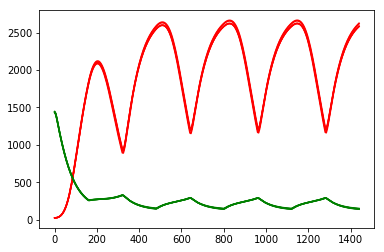

In [15]:
p = pM3[0:5,:]
test = solveALL(t,p,evnT,[1e-7,100,1,1e-7]*4+[1e-7,100],ivss,pre, 'M3')
plt.figure()
plt.plot(t[::5], test[:,0:5], 'r')
plt.plot(t[::5], test[:,5:10], 'g')
plt.show()

### Bhattacharyya distance function:

In [6]:

def BhattacharyyaDist (mu1, mu2, sd1, sd2):
    E = (sd1+sd2)/2
    Em1 = np.linalg.inv(E)
    dE = abs(np.linalg.det(E))

    t1 = np.matrix.transpose((np.matrix.transpose(np.matrix(mu1))-np.matrix.transpose(np.matrix(mu2))))
    t2 = np.matrix.transpose(np.matrix(mu1))-np.matrix.transpose(np.matrix(mu2))
    
    ft = (1/8)*t1*Em1*t2
    st = dE/np.sqrt(abs(np.linalg.det(sd1))*abs(np.linalg.det(sd2)))
    
    bhd = ft+0.5*np.log(st)
    
    return(float(bhd))



### Definition of the utility function:

In [7]:

def utility2 (IPTG1, IPTG2, IPTG3, IPTG4,
             aTc1, aTc2, aTc3, aTc4):
    
    # Definition of inputs for the ODEs
        
    inputs = [round(IPTG1,2)+1e-7, int(aTc1)+1e-7, round(IPTG2,2)+1e-7, int(aTc2)+1e-7,
              round(IPTG3,2)+1e-7, int(aTc3)+1e-7, round(IPTG4,2)+1e-7, int(aTc4)+1e-7]
    
    # Initial values for steady state and inputs
    ivss = [1,1e-7,1363.193,28.510]
    pre = [1,1e-7]
    # Event switches and inputs
    sp = [int(i) for i in list(np.linspace(0,(24*60),5))]
    t =  np.linspace(0,(24*60),(24*60)+1)
    
    # load parameter draws for the two models
    pM1 = np.asarray(pd.read_csv("ParametersCSV/drawsRedT_ALL_Model1.stan.csv"))
    pM2 = np.asarray(pd.read_csv("ParametersCSV/drawsRedT_ALL_Model2.stan.csv"))
    
    # Simulation of the system for the two models and extract of results
    solM1 = solveALL(t, pM1, sp, inputs, ivss, pre, 'M1')
    solM2 = solveALL(t, pM2, sp, inputs, ivss, pre, 'M2')
    
    RFP_M1 = solM1[:,0:len(pM1[:,1])]
    GFP_M1 = solM1[:,len(pM1[:,1]):(len(pM1[:,1])*2)]
    
    RFP_M2 = solM2[:,0:len(pM2[:,1])]
    GFP_M2 = solM2[:,len(pM2[:,1]):(len(pM2[:,1])*2)]
    
    # Gaussian Process Regression and Reduction
    
    # Means and standard deviations for each time point for each species and for each model
    tgp = np.linspace(0,(24*60),round(24*60/5)+1)
    
    muR3 = RFP_M2.mean(axis = 1) # Model 2, RFP
    sdR3 = RFP_M2.std(axis = 1)
    muG3 = GFP_M2.mean(axis = 1) # Model 2, GFP
    sdG3 = GFP_M2.std(axis = 1)
    muR2 = RFP_M1.mean(axis = 1) # Model 1, RFP
    sdR2 = RFP_M1.std(axis = 1)
    muG2 = GFP_M1.mean(axis = 1) # Model 1, GFP
    sdG2 = GFP_M1.std(axis = 1)

    # Gaussian Process regression
    gR3= gp.sqexpGP({0:(4, 10), 1: (-4, -2), 2: (-3,-1)}, tgp, muR3, (sdR3**2)) # RFP, Model 2
    gR3.findhyperparameters(noruns=15, optmessages = False, quiet = True)
    gR3.predict(tgp)
    
    gG3= gp.sqexpGP({0:(4, 10), 1: (-4, -2), 2: (-3,-1)}, tgp, muG3, (sdG3**2)) # GFP, Model 2
    gG3.findhyperparameters(noruns=15, optmessages = False, quiet = True)
    gG3.predict(tgp)
    
    gR2= gp.sqexpGP({0:(4, 10), 1: (-4, -2), 2: (-3,-1)}, tgp, muR2, (sdR2**2)) # RFP, Model 1
    gR2.findhyperparameters(noruns=15, optmessages = False, quiet = True)
    gR2.predict(tgp)
    
    gG2= gp.sqexpGP({0:(4, 10), 1: (-4, -2), 2: (-3,-1)}, tgp, muG2, (sdG2**2)) # GFP, Model 1
    gG2.findhyperparameters(noruns=15, optmessages = False, quiet = True)
    gG2.predict(tgp)
    
    # Time points reduction

    muref = list(np.matrix.transpose((np.random.multivariate_normal(gR3.mnp, gR3.covp, 2000)))[::10])
    tref = list(tgp[::10])

    g2R3= gp.sqexpGP({0:(4, 10), 1: (-6, -3), 2: (1,4)}, tref, np.asarray(muref).mean(axis=1), np.asarray(muref).std(axis=1)**2)
    g2R3.findhyperparameters(noruns=15, optmessages = True, quiet = True)
    g2R3.predict(tref)

    
    muref = list(np.matrix.transpose((np.random.multivariate_normal(gR2.mnp, gR2.covp, 2000)))[::10])
    tref = list(tgp[::10])

    g2R2= gp.sqexpGP({0:(4, 10), 1: (-6, -3), 2: (1,4)}, tref, np.asarray(muref).mean(axis=1), np.asarray(muref).std(axis=1)**2)
    g2R2.findhyperparameters(noruns=15, optmessages = True, quiet = True)
    g2R2.predict(tref)

    
    muref = list(np.matrix.transpose((np.random.multivariate_normal(gG3.mnp, gG3.covp, 2000)))[::10])
    tref = list(tgp[::10])

    g2G3= gp.sqexpGP({0:(4, 10), 1: (-6, -3), 2: (1,4)}, tref, np.asarray(muref).mean(axis=1), np.asarray(muref).std(axis=1)**2)
    g2G3.findhyperparameters(noruns=15, optmessages = True, quiet = True)
    g2G3.predict(tref)

    
    muref = list(np.matrix.transpose((np.random.multivariate_normal(gG2.mnp, gG2.covp, 2000)))[::10])
    tref = list(tgp[::10])

    
    g2G2= gp.sqexpGP({0:(4, 10), 1: (-6, -3), 2: (1,4)}, tref, np.asarray(muref).mean(axis=1), np.asarray(muref).std(axis=1)**2)
    g2G2.findhyperparameters(noruns=15, optmessages = True, quiet = True)
    g2G2.predict(tref)

    
    # Bhattacharyya distance:
    bdR = BhattacharyyaDist(g2R3.mnp, g2R2.mnp, g2R3.covp, g2R2.covp)
    bdG = BhattacharyyaDist(g2G3.mnp, g2G2.mnp, g2G3.covp, g2G2.covp)
    
    # Utility function value
    u_B = (bdR*bdG)

    return(u_B)
    


### Bayesian Optimisation: 

In [8]:
# Bounded region of parameter space

pbounds = {'IPTG1': (0, 1), 'IPTG2': (0, 1), 'IPTG3': (0, 1), 'IPTG4': (0, 1),
           'aTc1': (0, 100), 'aTc2': (0, 100), 'aTc3': (0, 100), 'aTc4': (0, 100)}


Setting Bayesian Optimisation with our utility function

In [9]:
optimizer3 = BayesianOptimization(
    f=utility2,
    pbounds=pbounds,
    verbose=2, # verbose = 1 prints only when a maximum is observed, verbose = 0 is silent
    random_state=1324,
) 

Begin optimisation rutine

In [17]:
optimizer3.maximize(
    init_points=0,
    n_iter=397,
    alpha=1e-2,
    n_restarts_optimizer=3, 
#     acq="ei", 
#     xi=1e-4
)

|   iter    |  target   |   IPTG1   |   IPTG2   |   IPTG3   |   IPTG4   |   aTc1    |   aTc2    |   aTc3    |   aTc4    |
-------------------------------------------------------------------------------------------------------------------------
|  408      |  6.944e+0 |  0.3264   |  0.8329   |  0.3316   |  0.966    |  33.95    |  19.31    |  21.37    |  33.22    |
|  409      |  1.602e+0 |  0.5827   |  0.7219   |  0.8665   |  0.4394   |  37.07    |  19.36    |  22.46    |  32.17    |
|  410      |  1.66e+10 |  0.8675   |  0.6478   |  0.5147   |  0.7432   |  33.99    |  25.53    |  22.14    |  36.34    |
|  411      |  9.413e+0 |  0.7552   |  0.452    |  0.3566   |  0.8024   |  32.29    |  26.3     |  21.78    |  34.45    |
|  412      |  6.074e+0 |  0.5151   |  0.315    |  0.8125   |  0.1445   |  31.32    |  23.45    |  21.74    |  32.14    |
|  413      |  2.099e+0 |  0.2321   |  0.9767   |  0.555    |  0.7977   |  32.18    |  27.35    |  21.34    |  37.81    |
|  414      |  6.774e+0 

|  421      |  9.582e+0 |  0.5161   |  0.8296   |  0.3882   |  0.0129   |  31.19    |  28.19    |  24.38    |  36.21    |
|  422      |  4.974e+0 |  0.829    |  0.9659   |  0.7003   |  0.5253   |  32.78    |  25.37    |  22.44    |  37.83    |
|  423      |  1.435e+0 |  0.8365   |  0.8596   |  0.219    |  0.966    |  31.59    |  21.15    |  21.23    |  30.3     |
|  424      |  3.354e+0 |  0.1485   |  0.9022   |  0.3549   |  0.2079   |  41.79    |  20.8     |  31.44    |  34.64    |
|  425      |  6.703e+0 |  0.216    |  0.01623  |  0.2336   |  0.8964   |  33.27    |  19.8     |  18.89    |  34.0     |
|  426      |  3.627e+0 |  0.6746   |  0.4609   |  0.266    |  0.8701   |  29.79    |  26.79    |  17.49    |  36.73    |
|  427      |  1.915e+0 |  0.712    |  0.01182  |  0.8946   |  0.9343   |  31.88    |  27.45    |  24.77    |  35.97    |
|  428      |  1.135e+0 |  0.5061   |  0.3282   |  0.4072   |  0.9151   |  38.7     |  23.15    |  27.43    |  33.11    |
|  429      |  3.279e+0 

|  433      |  9.52e+07 |  0.7866   |  0.6874   |  0.2033   |  0.4566   |  29.94    |  25.8     |  26.29    |  36.39    |
|  434      |  4.238e+0 |  0.2834   |  0.4974   |  0.2737   |  0.4037   |  33.62    |  26.98    |  21.17    |  39.43    |
|  435      |  2.036e+0 |  0.0527   |  0.3272   |  0.891    |  0.2282   |  35.06    |  18.56    |  30.37    |  35.75    |
|  436      |  1.498e+0 |  0.8661   |  0.9327   |  0.133    |  0.826    |  29.11    |  28.03    |  19.42    |  35.78    |
|  437      |  2.235e+0 |  0.02139  |  0.09255  |  0.8111   |  0.2951   |  31.67    |  27.39    |  17.31    |  34.69    |
|  438      |  1.592e+0 |  0.2541   |  0.7557   |  0.1297   |  0.442    |  33.04    |  21.68    |  19.93    |  31.5     |
|  439      |  1.155e+0 |  0.9386   |  0.9966   |  0.9229   |  0.8791   |  38.86    |  18.29    |  22.57    |  33.16    |
|  440      |  8.89e+08 |  0.6303   |  0.5073   |  0.5523   |  0.4035   |  42.14    |  21.57    |  29.46    |  33.27    |
|  441      |  8.592e+0 

|  445      |  1.889e+0 |  0.8773   |  0.2613   |  0.8695   |  0.1949   |  29.41    |  25.93    |  18.97    |  35.12    |
|  446      |  1.196e+1 |  0.3871   |  0.4331   |  0.5756   |  0.8123   |  39.7     |  22.55    |  29.98    |  32.53    |
|  447      |  6.536e+0 |  0.41     |  0.731    |  0.8032   |  0.9172   |  32.12    |  21.76    |  23.12    |  30.93    |
|  448      |  6.017e+0 |  0.1185   |  0.1994   |  0.4499   |  0.757    |  37.67    |  21.64    |  22.62    |  31.83    |
|  449      |  5.503e+0 |  0.3445   |  0.7364   |  0.3411   |  0.1648   |  38.0     |  24.02    |  29.09    |  33.85    |
|  450      |  2.729e+0 |  0.2844   |  0.2383   |  0.537    |  0.3178   |  37.51    |  21.93    |  22.66    |  32.51    |
|  451      |  3.736e+0 |  0.2278   |  0.3459   |  0.6206   |  0.7325   |  32.44    |  26.12    |  22.24    |  37.54    |
|  452      |  1.324e+1 |  0.667    |  0.6064   |  0.5497   |  0.9113   |  32.11    |  21.03    |  21.68    |  33.72    |
|  453      |  5.188e+0 

|  458      |  1.641e+0 |  0.6384   |  0.1893   |  0.1044   |  0.1302   |  31.27    |  27.16    |  22.3     |  36.8     |
|  459      |  2.681e+0 |  0.3865   |  0.2923   |  0.1231   |  0.1202   |  41.44    |  22.61    |  29.95    |  32.17    |
|  460      |  1.366e+0 |  0.9277   |  0.07728  |  0.3531   |  0.8693   |  32.05    |  23.41    |  20.74    |  33.25    |
|  461      |  2.938e+0 |  0.2326   |  0.9062   |  0.5455   |  0.6405   |  32.69    |  20.45    |  18.6     |  30.75    |
|  462      |  2.148e+0 |  0.4136   |  0.3785   |  0.8843   |  0.04876  |  31.16    |  28.52    |  19.14    |  35.39    |
|  463      |  3.525e+0 |  0.7503   |  0.4343   |  0.977    |  0.8383   |  37.39    |  22.69    |  22.33    |  31.0     |
|  464      |  1.117e+1 |  0.3121   |  0.6763   |  0.9069   |  0.8831   |  34.63    |  22.18    |  22.99    |  32.32    |
|  465      |  1.72e+09 |  0.9762   |  0.3287   |  0.5186   |  0.7992   |  39.33    |  20.23    |  22.38    |  33.52    |
|  466      |  2.775e+0 

|  470      |  8.971e+0 |  0.05308  |  0.2509   |  0.6034   |  0.4096   |  33.11    |  18.3     |  21.11    |  32.22    |
|  471      |  1.194e+0 |  0.2796   |  0.7253   |  0.4005   |  0.2879   |  31.25    |  25.92    |  24.27    |  37.69    |
|  472      |  2.033e+0 |  0.3297   |  0.9051   |  0.8719   |  0.4584   |  31.82    |  20.67    |  24.01    |  31.4     |
|  473      |  2.429e+0 |  0.08767  |  0.3092   |  0.03865  |  0.7714   |  31.95    |  18.58    |  20.06    |  32.66    |
|  474      |  6.232e+0 |  0.9253   |  0.4956   |  0.4169   |  0.6242   |  40.41    |  21.84    |  30.74    |  32.79    |
|  475      |  7.96e+07 |  0.3835   |  0.9855   |  0.2221   |  0.8372   |  37.47    |  21.4     |  28.76    |  34.65    |
|  476      |  1.551e+0 |  0.7554   |  0.004611 |  0.5667   |  0.3589   |  30.25    |  27.33    |  20.47    |  34.82    |
|  477      |  2.784e+0 |  0.7748   |  0.5656   |  0.2209   |  0.7919   |  39.73    |  19.84    |  22.99    |  34.55    |
|  478      |  1.065e+0 

|  482      |  9.888e+0 |  0.4138   |  0.06202  |  0.2657   |  0.7652   |  37.65    |  22.7     |  28.67    |  34.25    |
|  483      |  3.889e+0 |  0.787    |  0.3932   |  0.8325   |  0.9043   |  34.82    |  23.49    |  23.84    |  33.53    |
|  484      |  1.592e+0 |  0.4607   |  0.08583  |  0.5309   |  0.708    |  32.86    |  26.34    |  24.17    |  36.67    |
|  485      |  4.651e+0 |  0.1504   |  0.7552   |  0.4548   |  0.1334   |  31.93    |  21.48    |  24.51    |  30.49    |
|  486      |  8.183e+0 |  0.9205   |  0.1207   |  0.6184   |  0.7391   |  30.76    |  22.77    |  20.68    |  33.28    |
|  487      |  2.792e+0 |  0.2764   |  0.6736   |  0.8456   |  0.683    |  38.0     |  25.44    |  24.49    |  38.68    |
|  488      |  1.15e+08 |  0.3873   |  0.8946   |  0.9441   |  0.2054   |  31.1     |  20.14    |  24.61    |  30.9     |
|  489      |  5.57e+07 |  0.8737   |  0.3581   |  0.2203   |  0.3632   |  32.99    |  27.12    |  21.24    |  35.71    |
|  490      |  3.312e+0 

|  495      |  1.542e+0 |  0.9968   |  0.8751   |  0.7429   |  0.3195   |  31.37    |  25.3     |  25.84    |  36.96    |
|  496      |  8.686e+0 |  0.8657   |  0.8242   |  0.6206   |  0.05754  |  38.6     |  21.69    |  30.19    |  32.19    |
|  497      |  6.378e+0 |  0.2337   |  0.6822   |  0.6549   |  0.8364   |  32.99    |  23.6     |  22.06    |  37.41    |
|  498      |  1.856e+0 |  0.07422  |  0.6182   |  0.9924   |  0.9781   |  31.52    |  26.56    |  25.42    |  38.52    |
|  499      |  1.866e+0 |  0.2353   |  0.6418   |  0.408    |  0.8026   |  36.21    |  19.91    |  29.33    |  34.95    |
|  500      |  4.825e+0 |  0.3919   |  0.8327   |  0.875    |  0.05488  |  30.41    |  27.54    |  19.43    |  37.0     |
|  501      |  5.687e+0 |  0.5107   |  0.9089   |  0.6854   |  0.4979   |  30.83    |  20.94    |  21.56    |  34.74    |
|  502      |  2.547e+0 |  0.5982   |  0.8199   |  0.215    |  0.5603   |  34.56    |  29.33    |  21.62    |  35.96    |
|  503      |  2.757e+0 

|  506      |  1.622e+0 |  0.3622   |  0.953    |  0.6439   |  0.782    |  30.71    |  24.47    |  21.18    |  32.98    |
|  507      |  2.793e+0 |  0.3616   |  0.1282   |  0.03609  |  0.7575   |  31.64    |  28.5     |  19.47    |  34.32    |
|  508      |  4.875e+0 |  0.696    |  0.6573   |  0.8739   |  0.1692   |  32.79    |  25.59    |  20.78    |  37.18    |
|  509      |  2.757e+0 |  0.1669   |  0.2102   |  0.936    |  0.05641  |  31.64    |  19.76    |  20.34    |  30.99    |
|  510      |  1.311e+1 |  0.3981   |  0.4025   |  0.5662   |  0.9932   |  32.93    |  26.47    |  20.23    |  36.99    |
|  511      |  2.755e+0 |  0.2097   |  0.1652   |  0.788    |  0.6335   |  37.64    |  23.01    |  32.21    |  34.52    |
|  512      |  2.691e+0 |  0.8123   |  0.2931   |  0.3866   |  0.5936   |  31.19    |  21.66    |  23.43    |  29.64    |
|  513      |  2.712e+0 |  0.2026   |  0.8577   |  0.4883   |  0.7163   |  36.66    |  20.58    |  21.99    |  32.65    |
|  514      |  3.221e+0 

|  517      |  2.324e+0 |  0.01735  |  0.07589  |  0.7983   |  0.5815   |  36.59    |  25.02    |  20.57    |  38.99    |
|  518      |  2.493e+0 |  0.3135   |  0.4808   |  0.05533  |  0.3776   |  37.95    |  18.84    |  29.02    |  35.86    |
|  519      |  2.572e+0 |  0.6531   |  0.5485   |  0.6456   |  0.9207   |  40.47    |  23.16    |  32.08    |  32.78    |
|  520      |  1.109e+0 |  0.7565   |  0.9153   |  0.4904   |  0.1239   |  35.28    |  19.86    |  27.48    |  35.65    |
|  521      |  7.315e+0 |  0.7617   |  0.3676   |  0.2987   |  0.7559   |  30.36    |  20.78    |  23.18    |  31.01    |
|  522      |  2.773e+0 |  0.8839   |  0.3372   |  0.1678   |  0.633    |  33.85    |  23.92    |  23.25    |  36.52    |
|  523      |  8.199e+0 |  0.4553   |  0.3608   |  0.4518   |  0.03694  |  36.47    |  18.93    |  28.34    |  34.84    |
|  524      |  6.361e+0 |  0.6766   |  0.6836   |  0.4265   |  0.3763   |  31.35    |  22.94    |  22.15    |  32.56    |
|  525      |  6.022e+0 

|  528      |  2.811e+0 |  0.5779   |  0.659    |  0.5889   |  0.1401   |  38.47    |  24.38    |  31.06    |  31.88    |
|  529      |  5.126e+0 |  0.7516   |  0.853    |  0.3321   |  0.6283   |  33.61    |  21.73    |  21.37    |  33.56    |
|  530      |  2.57e+07 |  0.1327   |  0.02925  |  0.4861   |  0.8286   |  34.47    |  27.72    |  21.26    |  36.53    |
|  531      |  7.704e+0 |  0.3827   |  0.08417  |  0.831    |  0.874    |  38.22    |  22.32    |  27.86    |  32.91    |
|  532      |  4.591e+0 |  0.6425   |  0.7784   |  0.2677   |  0.2806   |  32.45    |  21.9     |  21.95    |  34.93    |
|  533      |  4.732e+0 |  0.8681   |  0.7387   |  0.1439   |  0.2216   |  36.19    |  21.3     |  28.67    |  33.12    |
|  534      |  7.097e+0 |  0.136    |  0.396    |  0.2026   |  0.1441   |  37.82    |  17.68    |  26.19    |  35.01    |
|  535      |  6.928e+0 |  0.3765   |  0.6052   |  0.302    |  0.9927   |  33.49    |  23.73    |  23.35    |  37.83    |
|  536      |  5.555e+0 

|  539      |  1.656e+0 |  0.09756  |  0.2293   |  0.09727  |  0.5458   |  73.66    |  30.19    |  42.9     |  31.8     |
|  540      |  1.216e+0 |  0.7569   |  0.1103   |  0.808    |  0.3478   |  33.19    |  87.61    |  2.157    |  25.98    |
|  541      |  1.257e+0 |  0.1595   |  0.7369   |  0.7314   |  0.1958   |  31.86    |  27.65    |  15.47    |  12.38    |
|  542      |  5.341e+0 |  0.6569   |  0.6076   |  0.7764   |  0.1039   |  36.56    |  82.47    |  31.41    |  2.68     |
|  543      |  1.09e+07 |  0.4393   |  0.6202   |  0.01328  |  0.4242   |  25.76    |  42.02    |  85.42    |  10.24    |
|  544      |  8.145e+0 |  0.1117   |  0.04406  |  0.5707   |  0.5589   |  78.98    |  9.236    |  49.53    |  77.4     |
|  545      |  7.212e+0 |  0.8971   |  0.4538   |  0.9502   |  0.1927   |  43.8     |  99.19    |  89.83    |  58.57    |
|  546      |  1.366e+0 |  0.1364   |  0.5049   |  0.6596   |  0.1915   |  77.05    |  80.03    |  94.77    |  80.05    |
|  547      |  1.056e+0 

|  550      |  3.761e+0 |  0.002637 |  0.5129   |  0.112    |  0.5194   |  58.12    |  71.99    |  77.3     |  20.04    |
|  551      |  6.5e+05  |  0.7765   |  0.7513   |  0.6589   |  0.8727   |  9.651    |  88.15    |  71.55    |  61.17    |
|  552      |  7.123e+0 |  0.9737   |  0.9121   |  0.4635   |  0.3477   |  64.58    |  0.3954   |  38.6     |  44.23    |
|  553      |  2.361e+0 |  0.5735   |  0.203    |  0.8212   |  0.8934   |  55.32    |  20.53    |  57.75    |  43.89    |
|  554      |  1.268e+0 |  0.09522  |  0.1439   |  0.3978   |  0.9784   |  53.33    |  25.58    |  91.43    |  55.19    |
|  555      |  1.617e+0 |  0.9442   |  0.6581   |  0.1849   |  0.5419   |  22.32    |  23.63    |  0.8273   |  62.04    |
|  556      |  9.931e+0 |  0.05119  |  0.6863   |  0.2826   |  0.8783   |  60.44    |  94.59    |  38.12    |  57.23    |
|  557      |  1.231e+0 |  0.5449   |  0.1061   |  0.3041   |  0.667    |  60.0     |  59.41    |  49.43    |  74.54    |
|  558      |  2.142e+0 

|  561      |  7.935e+0 |  0.6581   |  0.7092   |  0.03207  |  0.01344  |  81.63    |  69.98    |  29.82    |  99.71    |
|  562      |  3.891e+0 |  0.4126   |  0.4142   |  0.9448   |  0.7743   |  68.05    |  38.66    |  18.27    |  32.35    |
|  563      |  2.261e+0 |  0.8124   |  0.3623   |  0.5373   |  0.9469   |  68.18    |  72.63    |  33.9     |  98.71    |
|  564      |  1.59e+05 |  0.9112   |  0.1324   |  0.1422   |  0.8892   |  55.49    |  48.88    |  70.19    |  64.47    |
|  565      |  1.753e+0 |  0.1676   |  0.1008   |  0.7826   |  0.1796   |  49.32    |  66.55    |  52.43    |  75.55    |
|  566      |  3.121e+0 |  0.1513   |  0.3155   |  0.4706   |  0.9975   |  99.32    |  18.56    |  67.5     |  24.01    |
|  567      |  3.708e+0 |  0.6786   |  0.8217   |  0.1418   |  0.8583   |  24.27    |  72.96    |  40.37    |  30.01    |
|  568      |  1.23e+06 |  0.7072   |  0.9232   |  0.4465   |  0.7259   |  9.896    |  51.71    |  25.66    |  90.92    |
|  569      |  4.292e+0 

|  572      |  6.973e+0 |  0.7313   |  0.9451   |  0.6316   |  0.5545   |  7.043    |  79.56    |  69.93    |  0.1441   |
|  573      |  3.056e+0 |  0.3819   |  0.5511   |  0.99     |  0.8454   |  59.07    |  34.75    |  6.422    |  81.94    |
|  574      |  3.075e+0 |  0.7075   |  0.4366   |  0.5936   |  0.6588   |  16.21    |  99.42    |  95.12    |  81.14    |
|  575      |  9.968e+0 |  0.9893   |  0.3218   |  0.9642   |  0.589    |  68.14    |  74.67    |  77.91    |  92.07    |
|  576      |  6.652e+0 |  0.2266   |  0.3935   |  0.9719   |  0.6855   |  64.82    |  17.6     |  44.36    |  34.63    |
|  577      |  8.793e+0 |  0.2289   |  0.7201   |  0.1894   |  0.7114   |  49.03    |  27.28    |  20.83    |  69.27    |
|  578      |  1.475e+0 |  0.2788   |  0.7183   |  0.7812   |  0.01889  |  33.38    |  24.1     |  0.1428   |  20.93    |
|  579      |  1.006e+0 |  0.6296   |  0.3191   |  0.1496   |  0.908    |  16.05    |  92.12    |  67.09    |  9.42     |
|  580      |  2.709e+0 

|  583      |  3.118e+0 |  0.7071   |  0.3606   |  0.1192   |  0.4521   |  58.75    |  64.52    |  28.74    |  45.64    |
|  584      |  1.773e+0 |  0.05694  |  0.3046   |  0.4807   |  0.4523   |  67.43    |  77.63    |  35.66    |  71.82    |
|  585      |  8.113e+0 |  0.5665   |  0.1781   |  0.3489   |  0.7308   |  87.85    |  77.08    |  2.893    |  65.6     |
|  586      |  1.794e+0 |  0.02534  |  0.9169   |  0.2886   |  0.636    |  92.25    |  72.66    |  28.44    |  74.03    |
|  587      |  2.993e+0 |  0.6678   |  0.8097   |  0.222    |  0.252    |  11.76    |  61.19    |  83.12    |  82.32    |
|  588      |  7.043e+0 |  0.1814   |  0.4755   |  0.9402   |  0.7361   |  60.13    |  10.81    |  88.03    |  22.09    |
|  589      |  5.023e+0 |  0.2962   |  0.6802   |  0.3986   |  0.9297   |  68.47    |  80.67    |  80.48    |  58.84    |
|  590      |  1.618e+0 |  0.05095  |  0.6329   |  0.2079   |  0.5103   |  60.08    |  4.319    |  41.37    |  76.81    |
|  591      |  2.746e+0 

|  597      |  9.358e+0 |  0.4709   |  0.2307   |  0.5104   |  0.8279   |  15.19    |  10.62    |  6.031    |  83.69    |
|  598      |  1.438e+0 |  0.7881   |  0.4587   |  0.6532   |  0.9793   |  9.249    |  90.93    |  61.23    |  2.468    |
|  599      |  5.407e+0 |  0.852    |  0.9002   |  0.7933   |  0.9602   |  68.37    |  46.34    |  40.73    |  43.97    |
|  600      |  3.191e+0 |  0.6234   |  0.28     |  0.9784   |  0.2282   |  76.77    |  61.87    |  25.99    |  12.14    |
|  601      |  6.409e+0 |  0.02737  |  0.4355   |  0.122    |  0.3467   |  5.001    |  85.83    |  3.604    |  28.88    |
|  602      |  8.314e+0 |  0.88     |  0.5865   |  0.6581   |  0.2823   |  34.49    |  92.69    |  90.09    |  40.17    |
|  603      |  4.71e+05 |  0.7514   |  0.1962   |  0.5269   |  0.6373   |  78.65    |  22.67    |  93.75    |  37.11    |
|  604      |  9.293e+0 |  0.144    |  0.2741   |  0.04211  |  0.7487   |  91.9     |  52.84    |  41.15    |  29.42    |
|  605      |  7.599e+0 

|  607      |  2.606e+0 |  0.8199   |  0.2733   |  0.9632   |  0.8213   |  5.066    |  16.12    |  24.45    |  41.49    |
|  608      |  2.394e+0 |  0.9091   |  0.6947   |  0.3406   |  0.2046   |  63.69    |  1.629    |  79.68    |  67.46    |
|  609      |  2.023e+0 |  0.6126   |  0.2875   |  0.662    |  0.7669   |  53.5     |  24.16    |  58.06    |  64.77    |
|  610      |  1.183e+0 |  0.8636   |  0.6977   |  0.7429   |  0.5718   |  60.51    |  15.45    |  19.41    |  76.65    |
|  611      |  5.338e+0 |  0.2375   |  0.4679   |  0.2929   |  0.7238   |  30.02    |  7.185    |  61.67    |  10.67    |
|  612      |  1.134e+0 |  0.3744   |  0.469    |  0.1297   |  0.5492   |  62.83    |  58.87    |  85.33    |  9.833    |
|  613      |  7.945e+0 |  0.6531   |  0.7757   |  0.8465   |  0.5548   |  0.4679   |  12.01    |  51.64    |  91.46    |
|  614      |  6.127e+0 |  0.4767   |  0.8048   |  0.2994   |  0.01169  |  42.29    |  84.32    |  62.85    |  64.92    |
|  615      |  2.156e+0 

|  619      |  2.141e+0 |  0.1184   |  0.709    |  0.9046   |  0.1366   |  65.67    |  67.26    |  92.98    |  68.95    |
|  620      |  2.008e+0 |  0.9476   |  0.1121   |  0.1225   |  0.7695   |  85.19    |  70.1     |  5.613    |  8.534    |
|  621      |  4.052e+0 |  0.9485   |  0.1654   |  0.3132   |  0.3071   |  30.37    |  32.94    |  14.06    |  52.61    |
|  622      |  7.232e+0 |  0.9805   |  0.8912   |  0.6614   |  0.04333  |  79.75    |  88.58    |  14.43    |  48.85    |
|  623      |  1.267e+0 |  0.3405   |  0.07425  |  0.9213   |  0.5286   |  10.59    |  40.28    |  90.28    |  26.35    |
|  624      |  6.271e+0 |  0.5125   |  0.3513   |  0.3766   |  0.7404   |  20.24    |  21.53    |  18.6     |  35.78    |
|  625      |  7.803e+0 |  0.3526   |  0.8502   |  0.8077   |  0.918    |  97.09    |  34.5     |  76.1     |  64.21    |
|  626      |  3.04e+04 |  0.9749   |  0.6838   |  0.03291  |  0.9515   |  10.46    |  87.77    |  45.27    |  41.29    |
|  627      |  1.446e+0 

|  630      |  1.086e+0 |  0.1969   |  0.5715   |  0.004953 |  0.6071   |  35.31    |  35.62    |  47.1     |  92.65    |
|  631      |  4.704e+0 |  0.8414   |  0.1343   |  0.7134   |  0.09896  |  78.72    |  97.44    |  7.068    |  60.77    |
|  632      |  1.127e+0 |  0.7045   |  0.3377   |  0.1893   |  0.4182   |  88.74    |  63.96    |  49.03    |  12.57    |
|  633      |  1.193e+0 |  0.5161   |  0.5954   |  0.8718   |  0.2305   |  92.01    |  78.65    |  35.94    |  76.42    |
|  634      |  3.457e+0 |  0.2398   |  0.9955   |  0.995    |  0.9087   |  25.43    |  48.48    |  77.99    |  49.06    |
|  635      |  1.183e+0 |  0.2875   |  0.7485   |  0.9802   |  0.6973   |  41.2     |  61.31    |  97.97    |  63.29    |
|  636      |  8.542e+0 |  0.1918   |  0.01624  |  0.5247   |  0.2394   |  55.89    |  39.1     |  79.8     |  79.52    |
|  637      |  5.009e+0 |  0.5933   |  0.5719   |  0.1673   |  0.548    |  50.86    |  8.067    |  40.05    |  63.17    |
|  638      |  4.187e+0 

|  642      |  1.028e+0 |  0.5714   |  0.1887   |  0.1152   |  0.7593   |  30.27    |  1.726    |  62.63    |  45.72    |
|  643      |  3.574e+0 |  0.7186   |  0.9643   |  0.1012   |  0.1788   |  57.83    |  91.3     |  7.132    |  74.23    |
|  644      |  5.827e+0 |  0.6059   |  0.9988   |  0.2722   |  0.9846   |  66.61    |  18.64    |  92.55    |  39.09    |
|  645      |  2.939e+0 |  0.5242   |  0.0621   |  0.4027   |  0.4154   |  10.07    |  8.161    |  84.77    |  24.82    |
|  646      |  1.097e+0 |  0.5243   |  0.6142   |  0.9327   |  0.6842   |  99.26    |  23.81    |  74.38    |  44.08    |
|  647      |  1.26e+06 |  0.004918 |  0.6735   |  0.4191   |  0.1778   |  94.92    |  31.28    |  32.51    |  96.78    |
|  648      |  1.373e+0 |  0.6941   |  0.8885   |  0.3895   |  0.606    |  67.58    |  78.71    |  53.3     |  95.27    |
|  649      |  4.17e+05 |  0.2235   |  0.03843  |  0.2557   |  0.382    |  38.63    |  99.04    |  23.88    |  60.85    |
|  650      |  1.413e+0 

|  655      |  1.136e+0 |  0.5026   |  0.6777   |  0.3903   |  0.4536   |  2.984    |  89.03    |  54.16    |  10.91    |
|  656      |  6.332e+0 |  0.06035  |  0.4475   |  0.3489   |  0.9413   |  40.37    |  17.62    |  76.09    |  45.87    |
|  657      |  4.657e+0 |  0.04412  |  0.8392   |  0.961    |  0.8066   |  85.81    |  35.83    |  71.39    |  42.21    |
|  658      |  5.281e+0 |  0.04232  |  0.8093   |  0.6945   |  0.5467   |  91.79    |  55.63    |  55.54    |  21.83    |
|  659      |  9.324e+0 |  0.6181   |  0.682    |  0.0276   |  0.01343  |  85.72    |  24.45    |  4.604    |  45.56    |
|  660      |  1.091e+0 |  0.4142   |  0.6196   |  0.823    |  0.4231   |  30.4     |  98.63    |  4.031    |  6.857    |
|  661      |  1.903e+0 |  0.475    |  0.5879   |  0.7989   |  0.2183   |  21.14    |  96.3     |  19.63    |  31.51    |
|  662      |  3.699e+0 |  0.5869   |  0.4597   |  0.542    |  0.2886   |  99.67    |  71.36    |  25.63    |  54.83    |
|  663      |  1.471e+0 

|  667      |  8.817e+0 |  0.9905   |  0.03663  |  0.7671   |  0.3912   |  6.937    |  78.73    |  30.03    |  96.39    |
|  668      |  5.583e+0 |  0.06753  |  0.8589   |  0.825    |  0.07313  |  82.13    |  82.92    |  33.34    |  54.46    |
|  669      |  1.166e+0 |  0.9415   |  0.05921  |  0.6968   |  0.7094   |  37.11    |  11.77    |  14.46    |  67.71    |
|  670      |  6.754e+0 |  0.3865   |  0.1314   |  0.7744   |  0.7855   |  19.24    |  5.662    |  6.123    |  7.129    |
|  671      |  5.132e+0 |  0.2377   |  0.1568   |  0.8972   |  0.1078   |  14.28    |  76.37    |  43.22    |  39.21    |
|  672      |  4.15e+05 |  0.6376   |  0.3152   |  0.6484   |  0.6489   |  59.99    |  71.93    |  90.98    |  89.84    |
|  673      |  6.945e+0 |  0.9009   |  0.8149   |  0.2775   |  0.007386 |  34.32    |  3.893    |  63.59    |  54.3     |
|  674      |  1.007e+0 |  0.9241   |  0.5171   |  0.3647   |  0.08012  |  78.11    |  90.14    |  8.035    |  36.42    |
|  675      |  9.32e+06 

|  679      |  1.291e+0 |  0.921    |  0.8155   |  0.04985  |  0.1265   |  17.08    |  43.01    |  65.39    |  27.42    |
|  680      |  1.489e+0 |  0.2793   |  0.6643   |  0.6894   |  0.007536 |  48.62    |  76.23    |  6.625    |  24.75    |
|  681      |  3.612e+0 |  0.4809   |  0.2381   |  0.2225   |  0.5043   |  63.83    |  33.46    |  14.61    |  34.48    |
|  682      |  1.649e+0 |  0.887    |  0.314    |  0.04655  |  0.5837   |  13.77    |  83.9     |  65.94    |  23.05    |
|  683      |  3.408e+0 |  0.9382   |  0.05643  |  0.6964   |  0.2473   |  77.95    |  25.67    |  60.96    |  11.72    |
|  684      |  2.436e+0 |  0.5499   |  0.4128   |  0.7667   |  0.726    |  66.93    |  53.75    |  59.41    |  90.2     |
|  685      |  1.521e+0 |  0.4435   |  0.7073   |  0.9861   |  0.3843   |  33.65    |  67.1     |  19.22    |  20.91    |
|  686      |  1.747e+0 |  0.09098  |  0.00813  |  0.3952   |  0.1386   |  17.42    |  28.66    |  6.924    |  92.12    |
|  687      |  3.31e+06 

|  690      |  2.276e+0 |  0.1871   |  0.2935   |  0.1949   |  0.1205   |  28.79    |  35.02    |  57.93    |  31.36    |
|  691      |  1.923e+0 |  0.9613   |  0.7935   |  0.4416   |  0.9174   |  45.8     |  48.61    |  52.17    |  54.53    |
|  692      |  7.612e+0 |  0.3018   |  0.6765   |  0.3366   |  0.4749   |  29.95    |  26.66    |  74.68    |  50.8     |
|  693      |  3.955e+0 |  0.3663   |  0.07746  |  0.5762   |  0.8599   |  61.87    |  66.04    |  88.86    |  23.79    |
|  694      |  1.478e+0 |  0.6891   |  0.7032   |  0.5778   |  0.4173   |  64.74    |  51.25    |  95.73    |  78.74    |
|  695      |  1.205e+0 |  0.143    |  0.04698  |  0.3221   |  0.3536   |  30.46    |  22.85    |  40.55    |  12.0     |
|  696      |  6.275e+0 |  0.7149   |  0.6339   |  0.4709   |  0.1897   |  76.97    |  27.18    |  17.01    |  10.78    |
|  697      |  3.581e+0 |  0.6516   |  0.1507   |  0.06135  |  0.4862   |  97.76    |  51.63    |  81.51    |  27.65    |
|  698      |  4.245e+0 

|  701      |  4.066e+0 |  0.3515   |  0.2327   |  0.3845   |  0.0108   |  98.89    |  3.743    |  5.368    |  50.29    |
|  702      |  6.061e+0 |  0.3638   |  0.3799   |  0.3656   |  0.7779   |  30.3     |  84.57    |  64.14    |  68.41    |
|  703      |  7.084e+0 |  0.5944   |  0.4409   |  0.3373   |  0.2063   |  69.91    |  25.15    |  6.332    |  40.48    |
|  704      |  2.251e+0 |  0.9568   |  0.7581   |  0.8067   |  0.8232   |  19.14    |  60.05    |  60.22    |  14.65    |
|  705      |  1.566e+0 |  0.4832   |  0.8191   |  0.2837   |  0.8967   |  46.58    |  25.59    |  74.3     |  4.039    |
|  706      |  1.532e+0 |  0.9244   |  0.3682   |  0.345    |  0.952    |  7.764    |  7.505    |  86.73    |  41.7     |
|  707      |  6.717e+0 |  0.4174   |  0.7703   |  0.7573   |  0.5869   |  6.958    |  20.06    |  3.642    |  39.53    |
|  708      |  2.906e+0 |  0.7943   |  0.2888   |  0.6073   |  0.0908   |  99.1     |  11.11    |  20.96    |  40.97    |
|  709      |  3.534e+0 

|  712      |  2.229e+0 |  0.7208   |  0.4047   |  0.6745   |  0.04348  |  6.245    |  13.73    |  26.18    |  56.4     |
|  713      |  2.068e+0 |  0.5232   |  0.4344   |  0.6672   |  0.1188   |  60.4     |  87.68    |  93.3     |  46.4     |
|  714      |  1.718e+0 |  0.225    |  0.6799   |  0.6802   |  0.9865   |  76.69    |  72.46    |  40.54    |  86.08    |
|  715      |  3.595e+0 |  0.001709 |  0.03821  |  0.6619   |  0.47     |  17.32    |  3.813    |  46.71    |  35.53    |
|  716      |  3.272e+0 |  0.4785   |  0.3112   |  0.2033   |  0.9265   |  50.05    |  39.22    |  9.171    |  63.48    |
|  717      |  1.35e+07 |  0.9782   |  0.4746   |  0.5235   |  0.3191   |  28.33    |  42.75    |  45.59    |  69.22    |
|  718      |  8.791e+0 |  0.2607   |  0.1063   |  0.2684   |  0.6991   |  59.98    |  37.71    |  40.53    |  80.19    |
|  719      |  6.197e+0 |  0.708    |  0.8525   |  0.756    |  0.3159   |  75.13    |  92.63    |  0.2498   |  38.39    |
|  720      |  1.713e+0 

|  724      |  5.653e+0 |  0.2011   |  0.5072   |  0.5161   |  0.302    |  22.81    |  29.18    |  87.27    |  16.4     |
|  725      |  1.336e+0 |  0.7809   |  0.4317   |  0.8617   |  0.5541   |  82.22    |  36.07    |  77.55    |  86.36    |
|  726      |  1.669e+0 |  0.4541   |  0.3856   |  0.1491   |  0.4611   |  71.99    |  33.36    |  74.66    |  17.09    |
|  727      |  5.888e+0 |  0.4887   |  0.9939   |  0.65     |  0.5911   |  76.47    |  3.292    |  3.341    |  41.22    |
|  728      |  3.553e+0 |  0.8275   |  0.1888   |  0.944    |  0.638    |  20.3     |  89.53    |  94.21    |  54.39    |
|  729      |  1.319e+0 |  0.2342   |  0.9356   |  0.4664   |  0.1981   |  51.33    |  93.07    |  26.48    |  6.329    |
|  730      |  9.693e+0 |  0.5673   |  0.9923   |  0.2253   |  0.8358   |  90.19    |  50.95    |  4.026    |  17.38    |
|  731      |  7.332e+0 |  0.2606   |  0.6224   |  0.1668   |  0.5585   |  72.66    |  85.63    |  11.71    |  42.92    |
|  732      |  5.175e+0 

|  736      |  1.009e+0 |  0.8118   |  0.06619  |  0.8935   |  0.3778   |  51.33    |  29.15    |  94.82    |  92.43    |
|  737      |  2.329e+0 |  0.6435   |  0.606    |  0.2284   |  0.4442   |  81.05    |  82.9     |  96.09    |  29.28    |
|  738      |  1.718e+0 |  0.3095   |  0.6558   |  0.05316  |  0.8319   |  92.81    |  86.7     |  93.91    |  25.08    |
|  739      |  1.423e+0 |  0.05641  |  0.8195   |  0.3818   |  0.4097   |  15.27    |  0.8489   |  37.0     |  63.34    |
|  740      |  3.989e+0 |  0.8096   |  0.8929   |  0.6829   |  0.06326  |  21.84    |  37.1     |  58.52    |  96.77    |
|  741      |  2.824e+0 |  0.9907   |  0.3981   |  0.9373   |  0.956    |  97.25    |  91.18    |  94.25    |  29.85    |
|  742      |  3.585e+0 |  0.7528   |  0.3027   |  0.3416   |  0.6693   |  91.57    |  98.04    |  18.19    |  25.83    |
|  743      |  7.488e+0 |  0.578    |  0.05278  |  0.7847   |  0.9568   |  97.05    |  19.39    |  73.95    |  34.24    |
|  744      |  3.812e+0 

|  748      |  4.345e+0 |  0.008968 |  0.5694   |  0.8408   |  0.774    |  94.47    |  68.0     |  2.566    |  41.78    |
|  749      |  9.305e+0 |  0.4929   |  0.3932   |  0.7284   |  0.7643   |  28.12    |  60.37    |  89.02    |  57.64    |
|  750      |  4.431e+0 |  0.9481   |  0.434    |  0.5505   |  0.956    |  60.91    |  96.92    |  91.77    |  60.02    |
|  751      |  2.912e+0 |  0.8333   |  0.02219  |  0.6286   |  0.09226  |  89.15    |  82.3     |  12.81    |  9.709    |
|  752      |  4.837e+0 |  0.9081   |  0.03352  |  0.8021   |  0.8273   |  5.439    |  52.32    |  38.17    |  85.28    |
|  753      |  1.418e+0 |  0.4978   |  0.6999   |  0.9628   |  0.09914  |  99.34    |  65.6     |  38.53    |  29.69    |
|  754      |  7.586e+0 |  0.3397   |  0.9423   |  0.9474   |  0.7224   |  34.3     |  54.71    |  26.24    |  91.97    |
|  755      |  3.233e+0 |  0.8847   |  0.1511   |  0.5022   |  0.8621   |  70.39    |  10.78    |  46.32    |  84.96    |
|  756      |  1.363e+0 

|  761      |  3.229e+0 |  0.4527   |  0.2282   |  0.2071   |  0.928    |  8.928    |  70.62    |  51.45    |  78.76    |
|  762      |  4.82e+06 |  0.429    |  0.1974   |  0.204    |  0.8636   |  33.83    |  55.55    |  10.9     |  74.17    |
|  763      |  9.587e+0 |  0.1142   |  0.7899   |  0.125    |  0.3158   |  24.37    |  7.809    |  54.36    |  22.63    |
|  764      |  5.728e+0 |  0.7549   |  0.5058   |  0.504    |  0.9007   |  91.83    |  55.16    |  76.94    |  52.34    |
|  765      |  2.855e+0 |  0.3433   |  0.3199   |  0.4088   |  0.2012   |  56.22    |  24.26    |  73.42    |  80.57    |
|  766      |  9.392e+0 |  0.09612  |  0.2211   |  0.7054   |  0.3329   |  1.238    |  3.538    |  45.3     |  90.03    |
|  767      |  3.554e+0 |  0.943    |  0.5398   |  0.6866   |  0.9539   |  79.15    |  54.16    |  38.67    |  38.07    |
|  768      |  1.546e+0 |  0.3564   |  0.4779   |  0.9615   |  0.9075   |  16.8     |  66.82    |  60.61    |  18.23    |
|  769      |  1.967e+0 

|  772      |  2.162e+0 |  0.2975   |  0.3254   |  0.09743  |  0.1153   |  25.94    |  53.76    |  11.98    |  73.18    |
|  773      |  2.699e+0 |  0.7533   |  0.7142   |  0.1323   |  0.6982   |  50.64    |  59.19    |  9.824    |  60.04    |
|  774      |  3.086e+0 |  0.4424   |  0.07267  |  0.01557  |  0.9618   |  48.39    |  3.197    |  87.78    |  88.55    |
|  775      |  2.635e+0 |  0.3822   |  0.6284   |  0.6417   |  0.4084   |  62.17    |  23.31    |  17.65    |  1.372    |
|  776      |  7.694e+0 |  0.6699   |  0.7965   |  0.2433   |  0.8943   |  5.453    |  37.26    |  34.21    |  80.8     |
|  777      |  1.661e+0 |  0.1846   |  0.5292   |  0.6773   |  0.5173   |  18.4     |  82.41    |  12.84    |  94.39    |
|  778      |  6.38e+06 |  0.09851  |  0.9642   |  0.5767   |  0.4028   |  30.0     |  73.85    |  45.75    |  49.2     |
|  779      |  2.683e+0 |  0.4312   |  0.3666   |  0.3714   |  0.497    |  19.59    |  40.16    |  82.08    |  84.1     |
|  780      |  1.458e+0 

|  785      |  3.957e+0 |  0.8324   |  0.582    |  0.1725   |  0.9604   |  38.23    |  22.76    |  30.9     |  30.31    |
|  786      |  9.229e+0 |  0.3887   |  0.7773   |  0.5605   |  0.7316   |  83.47    |  14.21    |  65.29    |  35.68    |
|  787      |  2.526e+0 |  0.2875   |  0.8889   |  0.4631   |  0.9575   |  84.69    |  88.61    |  22.16    |  35.89    |
|  788      |  4.233e+0 |  0.7419   |  0.8122   |  0.7171   |  0.3446   |  23.35    |  35.68    |  20.29    |  81.12    |
|  789      |  4.665e+0 |  0.5732   |  0.5407   |  0.8179   |  0.4685   |  97.97    |  7.799    |  53.48    |  14.11    |
|  790      |  1.336e+0 |  0.7886   |  0.2941   |  0.6886   |  0.9426   |  46.24    |  72.71    |  37.4     |  1.662    |
|  791      |  9.923e+0 |  0.9069   |  0.9418   |  0.3771   |  0.7345   |  67.91    |  68.55    |  9.566    |  63.04    |
|  792      |  2.981e+0 |  0.2844   |  0.02386  |  0.7458   |  0.01974  |  98.58    |  68.18    |  96.58    |  15.79    |
|  793      |  1.165e+0 

|  799      |  4.864e+0 |  0.9277   |  0.9128   |  0.8842   |  0.1232   |  35.08    |  83.17    |  25.19    |  12.03    |
|  800      |  5.745e+0 |  0.7348   |  0.5746   |  0.7921   |  0.2118   |  84.36    |  61.19    |  79.68    |  20.61    |
|  801      |  2.367e+0 |  0.5581   |  0.08932  |  0.7841   |  0.9081   |  32.12    |  76.21    |  72.46    |  96.52    |
|  802      |  8.672e+0 |  0.2586   |  0.2896   |  0.8      |  0.1105   |  69.64    |  75.7     |  52.83    |  4.076    |
|  803      |  1.298e+0 |  0.6229   |  0.3018   |  0.8405   |  0.9089   |  97.39    |  59.31    |  25.56    |  46.58    |
|  804      |  2.286e+0 |  0.8789   |  0.3621   |  0.8034   |  0.1792   |  67.03    |  67.12    |  17.84    |  37.12    |


In [18]:
# Save results obtained
with open('config4sMultiplicative2.optim', 'wb') as config_optim_file:
 
    pickle.dump(optimizer3, config_optim_file)
    

In [19]:
# Best utility value generated
print(optimizer3.max)

{'target': 30097285048.627243, 'params': {'IPTG1': 0.4876235004904913, 'IPTG2': 0.5249763783483532, 'IPTG3': 0.4824738563719909, 'IPTG4': 0.64770745585826, 'aTc1': 32.980094069361876, 'aTc2': 26.87747914087954, 'aTc3': 21.569867378822856, 'aTc4': 37.072985391357335}}


Plot best utility value so far per iteration: 

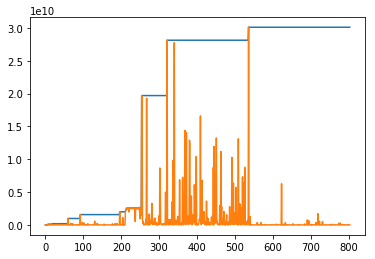

In [20]:
v = []
for i, res in enumerate(optimizer3.res):
    v.append(res['target'])
    
vn = []
for i, val in enumerate(v):
    mv = max(v[0:i+1])
    vn.append(mv)
    
plt.figure()
plt.plot(vn)
plt.plot(v)
plt.show()

In [21]:
df = pd.DataFrame({
    'CFV': v})
df.to_csv('CFV_Iter_4S_Multiplicative.csv')

df = pd.DataFrame({
    'CFV': vn})
df.to_csv('bestCFV_Iter_4S_Multiplicative.csv')

### Check results with plot

In [15]:
inputs = [round(optimizer3.max['params']['IPTG1'], 2)+1e-7, int(optimizer3.max['params']['aTc1'])+1e-7, 
          round(optimizer3.max['params']['IPTG2'], 2)+1e-7, int(optimizer3.max['params']['aTc2'])+1e-7, 
          round(optimizer3.max['params']['IPTG3'], 2)+1e-7, int(optimizer3.max['params']['aTc3'])+1e-7, 
          round(optimizer3.max['params']['IPTG4'], 2)+1e-7, int(optimizer3.max['params']['aTc4'])+1e-7]

ivss = [1,1e-7,1363.193,28.510]
pre = [1,1e-7]
sp = [int(i) for i in list(np.linspace(0,(24*60),5))]
t =  np.linspace(0,(24*60),(24*60)+1)

pM1 = np.asarray(pd.read_csv("ParametersCSV/drawsRedT_ALL_Model1.stan.csv"))
pM2 = np.asarray(pd.read_csv("ParametersCSV/drawsRedT_ALL_Model2.stan.csv"))

# Simulation of the system for the two models and extract of results
solM1 = solveALL(t, pM1, sp, inputs, ivss, pre, 'M1')
solM2 = solveALL(t, pM2, sp, inputs, ivss, pre, 'M2')

RFP_M1 = solM1[:,0:len(pM1[:,1])]
GFP_M1 = solM1[:,len(pM1[:,1]):(len(pM1[:,1])*2)]

RFP_M2 = solM2[:,0:len(pM2[:,1])]
GFP_M2 = solM2[:,len(pM2[:,1]):(len(pM2[:,1])*2)]


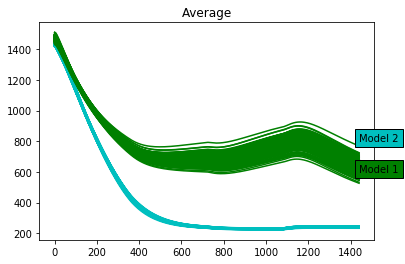

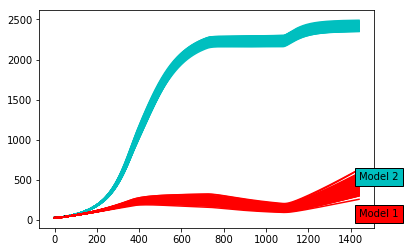

In [16]:
t = np.linspace(0,(24*60),round(24*60/5)+1)

plt.figure()
lines = plt.plot(t, GFP_M2, 'c')
plt.text((24*60)+1, 800, "Model 2", bbox=dict(facecolor='c'))
plt.title("Average")
lines2 = plt.plot(t, GFP_M1, 'g')
plt.text((24*60)+1, 600, "Model 1", bbox=dict(facecolor='g'))

plt.show()
plt.figure()
plt.plot(t, RFP_M2, 'c')

plt.text((24*60)+1, 500, "Model 2", bbox=dict(facecolor='c'))
plt.text((24*60)+1, 40, "Model 1", bbox=dict(facecolor='r'))
plt.plot(t, RFP_M1, 'r')
plt.show()

### Check utility decomposition results

In [ ]:
# Gaussian Process Regression and Reduction

# Means and standard deviations for each time point for each species and for each model
tgp = np.linspace(0,(24*60),(24*60/5)+1)

muR3 = RFP_M2.mean(axis = 1) # Model 2, RFP
sdR3 = RFP_M2.std(axis = 1)
muG3 = GFP_M2.mean(axis = 1) # Model 2, GFP
sdG3 = GFP_M2.std(axis = 1)
muR2 = RFP_M1.mean(axis = 1) # Model 1, RFP
sdR2 = RFP_M1.std(axis = 1)
muG2 = GFP_M1.mean(axis = 1) # Model 1, GFP
sdG2 = GFP_M1.std(axis = 1)

# Gaussian Process regression
gR3= gp.sqexpGP({0:(4, 10), 1: (-4, -2), 2: (-3,-1)}, tgp, muR3, (sdR3**2)) # RFP, Model 2
gR3.findhyperparameters(noruns=15)
gR3.predict(tgp)

gG3= gp.sqexpGP({0:(4, 10), 1: (-4, -2), 2: (-3,-1)}, tgp, muG3, (sdG3**2)) # GFP, Model 2
gG3.findhyperparameters(noruns=15)
gG3.predict(tgp)

gR2= gp.sqexpGP({0:(4, 10), 1: (-4, -2), 2: (-3,-1)}, tgp, muR2, (sdR2**2)) # RFP, Model 1
gR2.findhyperparameters(noruns=15)
gR2.predict(tgp)

gG2= gp.sqexpGP({0:(4, 10), 1: (-4, -2), 2: (-3,-1)}, tgp, muG2, (sdG2**2)) # GFP, Model 1
gG2.findhyperparameters(noruns=15)
gG2.predict(tgp)



In [ ]:
muref = list(np.matrix.transpose((np.random.multivariate_normal(gR3.mnp, gR3.covp, 2000)))[::10])
tref = list(tgp[::10])

g2R3= gp.sqexpGP({0:(4, 10), 1: (-6, -3), 2: (1,4)}, tref, np.asarray(muref).mean(axis=1), np.asarray(muref).std(axis=1)**2)
g2R3.findhyperparameters(noruns=15, optmessages = True, quiet = True)
g2R3.predict(tref)

muref = list(np.matrix.transpose((np.random.multivariate_normal(gR2.mnp, gR2.covp, 2000)))[::10])
tref = list(tgp[::10])

g2R2= gp.sqexpGP({0:(4, 10), 1: (-6, -3), 2: (1,4)}, tref, np.asarray(muref).mean(axis=1), np.asarray(muref).std(axis=1)**2)
g2R2.findhyperparameters(noruns=15, optmessages = True, quiet = True)
g2R2.predict(tref)

muref = list(np.matrix.transpose((np.random.multivariate_normal(gG3.mnp, gG3.covp, 2000)))[::10])
tref = list(tgp[::10])

g2G3= gp.sqexpGP({0:(4, 10), 1: (-6, -3), 2: (1,4)}, tref, np.asarray(muref).mean(axis=1), np.asarray(muref).std(axis=1)**2)
g2G3.findhyperparameters(noruns=15, optmessages = True, quiet = True)
g2G3.predict(tref)

muref = list(np.matrix.transpose((np.random.multivariate_normal(gG2.mnp, gG2.covp, 2000)))[::10])
tref = list(tgp[::10])

g2G2= gp.sqexpGP({0:(4, 10), 1: (-6, -3), 2: (1,4)}, tref, np.asarray(muref).mean(axis=1), np.asarray(muref).std(axis=1)**2)
g2G2.findhyperparameters(noruns=15, optmessages = True, quiet = True)
g2G2.predict(tref)

In [ ]:
bdR = BhattacharyyaDist(g2R3.mnp, g2R2.mnp, g2R3.covp, g2R2.covp)
bdG = BhattacharyyaDist(g2G3.mnp, g2G2.mnp, g2G3.covp, g2G2.covp)
u_B = (bdR*bdG)

In [ ]:
print("The BD for RFP is: ", str(bdR))
print("The BD for GFP is: ", str(bdG))
print("The multiplicative BD is: ", str(u_B))